<a href="https://colab.research.google.com/github/gverafei/artificial-networks-technologies/blob/main/tarea3/tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 3**
Oct 2025



## Instrucciones

A continuación, se enlista la definición del problema:

* Problema: reconocer 7 letras (A, B, C, D, E, J, K) con **63 píxeles** + **1 neurona de umbral** → entradas bipolares de dimensión **64**; salida de **7 neuronas** (una por clase) con vectores objetivo bipolares de 7D como `[1 -1 -1 -1 -1 -1 -1]` para “A”, etc. 
* **Mapeo de caracteres a bipolar**: `#` y `@` → `1`; `·` y `O` → `-1`.
* Los patrones de entrada son vectores en `{-1,1}^64`; las salidas deseadas en `{-1,1}^7`. Todos los **pesos se inicializan en cero**. 
* Arquitectura: red **feedforward fully connected** de **2 capas**: 64 (entrada con umbral) → 7 (salida). 

Hay **dos variantes** a implementar/entrenar/probar:

1. **Variante 1 (Hebb + escalón)**

   * Propagación: $\text{Net}_{j} = \sum_j w_{ij} x_j$
   * Activación: escalón (1 si $\text{Net}_j>0$, -1 en otro caso)
   * Salida: identidad
   * Aprendizaje (Hebb): $\Delta W_{ij} = \alpha, x_i ,(d_j - f(\text{Net}_j))$
   * Actualización: $ W_{ij}(t{+}1)=W_{ij}(t)+\Delta W_{ij} $.

2. **Variante 2 (Delta + tanh)**

   * Propagación: $ \text{Net}_j = \sum_j w_{ij} x_i $
   * Activación: $ f(\text{Net}_j)=\dfrac{1-e^{-2\text{Net}_j}}{1+e^{-2\text{Net}_j}}=\tanh(\text{Net}_j) $
   * Salida: identidad
   * Aprendizaje (Delta): $ \Delta W_{ij} = \alpha, x_i ,(d_j - f),(1+f),(1-f) $
     (equivale a $ \alpha, x_i ,(d_j - f),[1-f^2] $)
   * Actualización: $ W_{ij}(t{+}1)=W_{ij}(t)+\Delta W_{ij} $. 

---

Estos serían los pasos que realizaremos para conseguir los resultados:

* Parser de los 7×3 patrones (lectura desde archivos).
* Implementación común de forward para 64→7.
* Entrenamiento **Variante 1 (Hebb + escalón)** con evaluación por exactitud.
* Entrenamiento **Variante 2 (Delta + tanh)** con evaluación y curvas de error (LMSE/época).
* Matriz de confusión y reporte final.

### A. Configure virtual environment

Only execute these lines the first time. It will ask you to create a new virtual environment. In notebook, it might ask you to select a kernel from the upper right corner.

In [1]:
!python3 -m venv .venv

In [2]:
!source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

In [3]:
!pip install --upgrade pip --quiet

In [4]:
!pip install numpy --quiet

In [5]:
!pip install matplotlib --quiet

### 1. Parser de patrones ASCII a vectores bipolares

Primero definimos funciones para:

- Leer los archivos `.dat` de la carpeta `datos`.
- Mapear caracteres: `#` y `@` → `+1`, y `.`/`o`/`O`/espacio → `-1`.
- Convertir cada bloque de `9 × 7 = 63` píxeles en un vector.
- Agregar una neurona de **bias** con valor constante `+1`, de modo que cada patrón quede con **64 entradas**.

De esta forma, el conjunto de entrenamiento y prueba quedará representado como matrices `X_train` y `X_test` de forma `(N, 64)`, listas para usarse en las reglas de aprendizaje.


In [6]:
import numpy as np
from pathlib import Path

# ----------------------------
# Configuración del parser
# ----------------------------
ROWS_PER_PATTERN = 9   # 9 filas
COLS_PER_PATTERN = 7   # 7 columnas (9*7 = 63 pixeles)
POS_CHARS = {'#', '@'}                 # píxel "encendido" -> +1
NEG_CHARS = {'.', 'o', 'O', ' ', '\t'} # píxel "apagado"  -> -1

def char_to_bipolar(c: str) -> int:
    """Mapea un caracter ASCII a bipolar (+1/-1). Lanza error si aparece un char desconocido."""
    if c in POS_CHARS:
        return  +1
    if c in NEG_CHARS:
        return  -1
    # Si llega aquí, es un caracter no contemplado:
    raise ValueError(f"Caracter no mapeado en el dataset: {repr(c)}")

def read_ascii_lines(file_path: str) -> list[str]:
    """Lee todas las líneas no vacías del archivo y las devuelve sin salto de línea final."""
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        raw = f.readlines()
    # Filtra líneas vacías y quita '\n'
    lines = [ln.rstrip('\n') for ln in raw if ln.strip() != '']
    return lines

def lines_to_patterns(lines: list[str],
                      rows: int = ROWS_PER_PATTERN,
                      cols: int = COLS_PER_PATTERN) -> np.ndarray:
    """
    Convierte la lista de líneas ASCII en una matriz de patrones (N, rows, cols).
    Asume que los patrones están concatenados uno tras otro, cada uno con 'rows' líneas
    y cada línea con exactamente 'cols' caracteres.
    """
    # Validaciones básicas
    for i, ln in enumerate(lines, start=1):
        if len(ln) != cols:
            raise ValueError(f"Línea {i} tiene longitud {len(ln)} != {cols}. Contenido: {repr(ln)}")
    if len(lines) % rows != 0:
        raise ValueError(f"El número total de líneas ({len(lines)}) no es múltiplo de 'rows' ({rows}).")

    n_patterns = len(lines) // rows
    patterns = np.empty((n_patterns, rows, cols), dtype=int)

    # Construye bloques de rows en orden
    for p in range(n_patterns):
        block = lines[p*rows : (p+1)*rows]
        # Mapea cada char a bipolar
        grid = np.array([[char_to_bipolar(c) for c in row] for row in block], dtype=int)
        patterns[p] = grid

    return patterns

def flatten_and_add_bias(patterns_3d: np.ndarray, bias_at_end: bool = True) -> np.ndarray:
    """
    Aplana cada patrón (rows, cols) a vector (rows*cols,) y agrega la neurona de umbral (+1)
    como primer elemento (si bias_at_end=False) o como último elemento (si bias_at_end=True).
    Devuelve X con forma (N, rows*cols + 1).
    """
    n, r, c = patterns_3d.shape
    flat = patterns_3d.reshape(n, r*c)  # (N, 63)
    bias = np.ones((n, 1), dtype=int)   # (+1) por patrón

    if bias_at_end:
        X = np.hstack([flat, bias])     # (N, 64) -> último índice es el bias
    else:
        X = np.hstack([bias, flat])     # (N, 64) -> primer índice es el bias

    return X.astype(float)

def load_ascii_dataset(path: str | Path,
                       rows: int = ROWS_PER_PATTERN,
                       cols: int = COLS_PER_PATTERN,
                       bias_at_end: bool = True) -> np.ndarray:
    """
    Carga un archivo ASCII (.dat), convierte a patrones bipolares y agrega bias.
    Retorna X: np.ndarray de forma (N, rows*cols + 1).
    """
    lines = read_ascii_lines(str(path))
    patterns_3d = lines_to_patterns(lines, rows=rows, cols=cols)
    X = flatten_and_add_bias(patterns_3d, bias_at_end=bias_at_end)
    return X

# ----------------------------
# Leo los archivos de entrada en la carpeta "datos"
# ----------------------------
train_file = Path("datos") / "TRAIN.dat"
test_file  = Path("datos") / "TEST.dat"

X_train = load_ascii_dataset(train_file, rows=ROWS_PER_PATTERN, cols=COLS_PER_PATTERN, bias_at_end=True)
X_test  = load_ascii_dataset(test_file,  rows=ROWS_PER_PATTERN, cols=COLS_PER_PATTERN, bias_at_end=True)

print("Formas:", "X_train", X_train.shape, "| X_test", X_test.shape)
print("Valores únicos en X_train:", np.unique(X_train))
print("Primer vector para comprobar (64 dim, bias al final):\n", X_train[0].astype(int))


Formas: X_train (21, 64) | X_test (21, 64)
Valores únicos en X_train: [-1.  1.]
Primer vector para comprobar (64 dim, bias al final):
 [-1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1  1
 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1  1  1]


### 2. Validar impresión de patrones ASCII ya convertidos en "TEST.dat" (solo para verificar que estoy leyendo bien)

In [7]:
# ----------------------------
# Validar impresión de patrones ASCII ya convertidos
# ----------------------------

# Recuperamos también la versión 3D (antes de aplanar y añadir bias)
train_lines = read_ascii_lines(str(train_file))
patterns_3d = lines_to_patterns(train_lines, rows=ROWS_PER_PATTERN, cols=COLS_PER_PATTERN)

def pretty_print_pattern(matrix):
    """
    Imprime la matriz de 9x7 en formato visual:
    +1 -> '#', -1 -> '.'
    """
    for row in matrix:
        line = "".join('#' if v == 1 else '.' for v in row)
        print(line)
    print()

print("Total de letras en TRAIN:", patterns_3d.shape[0])

# Imprimir todas las letras en TRAIN
for idx, pat in enumerate(patterns_3d):
    print(f"Letra {idx+1}:")
    print("Matriz bipolar 9x7:\n", pat)
    print("Visual reconstruida:")
    pretty_print_pattern(pat)


Total de letras en TRAIN: 21
Letra 1:
Matriz bipolar 9x7:
 [[-1 -1  1  1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1]
 [-1 -1  1 -1  1 -1 -1]
 [-1 -1  1 -1  1 -1 -1]
 [-1  1  1  1  1  1 -1]
 [-1  1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1  1 -1]
 [ 1  1  1 -1  1  1  1]]
Visual reconstruida:
..##...
...#...
...#...
..#.#..
..#.#..
.#####.
.#...#.
.#...#.
###.###

Letra 2:
Matriz bipolar 9x7:
 [[ 1  1  1  1  1  1 -1]
 [-1  1 -1 -1 -1 -1  1]
 [-1  1 -1 -1 -1 -1  1]
 [-1  1 -1 -1 -1 -1  1]
 [-1  1  1  1  1  1 -1]
 [-1  1 -1 -1 -1 -1  1]
 [-1  1 -1 -1 -1 -1  1]
 [-1  1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1  1 -1]]
Visual reconstruida:
######.
.#....#
.#....#
.#....#
.#####.
.#....#
.#....#
.#....#
######.

Letra 3:
Matriz bipolar 9x7:
 [[-1 -1  1  1  1  1  1]
 [-1  1 -1 -1 -1 -1  1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1  1]
 [-1 -1  1  1  1  1 -1]]
Visual reconstruida:
..#####
.#....#
#....

### 3. Construcción de vectores objetivo (targets) bipolares

Ya que tenemos `X_train` con los patrones de entrada, ahora definimos los **targets** para las 7 clases (A, B, C, D, E, J, K).  
Cada etiqueta se codifica como un vector en $\{-1, +1\}^7$ usando la convención one-vs-all:

- A → [+1, -1, -1, -1, -1, -1, -1]  
- B → [-1, +1, -1, -1, -1, -1, -1]  
- C → [-1, -1, +1, -1, -1, -1, -1]  
- D → [-1, -1, -1, +1, -1, -1, -1]  
- E → [-1, -1, -1, -1, +1, -1, -1]  
- J → [-1, -1, -1, -1, -1, +1, -1]  
- K → [-1, -1, -1, -1, -1, -1, +1]

#### Etiquetado automático para TRAIN (21 patrones = 7 letras × 3 repeticiones)

* El archivo `TRAIN.dat` contiene las letras en el orden `[A, B, C, D, E, J, K]` y este bloque se repite **3 veces**.  
* Generamos `labels_train` repitiendo esa secuencia y construimos `Y_train` en formato bipolar $\{-1,+1\}^7$.
* Lo mismo debo hacer para TEST.dat


In [8]:
CLASSES = ['A', 'B', 'C', 'D', 'E', 'J', 'K']

def label_to_bipolar(label: str, classes=CLASSES):
    y = -np.ones(len(classes), dtype=float)
    y[classes.index(label)] = +1.0
    return y

def labels_to_targets(labels: list[str], classes=CLASSES) -> np.ndarray:
    return np.vstack([label_to_bipolar(lbl, classes) for lbl in labels])

# --- Construir etiquetas para Y: 21 patrones = 7 clases * 3 repeticiones ---
def get_labels(X: np.ndarray, classes=CLASSES) -> list[str]:
    N_train = X.shape[0]
    n_classes = len(classes)

    if N_train % n_classes != 0:
        raise ValueError(f"N_train={N_train} no es múltiplo de {n_classes}. Revisa el archivo TRAIN.dat")

    reps = N_train // n_classes   # aquí debería ser 3
    labels = (classes * reps)  # repite en el mismo orden
    return labels

# Construimos las etiquetas de salida Y para TRAIN
labels_train = get_labels(X_train, classes=CLASSES)
Y_train = labels_to_targets(labels_train, CLASSES)

# print("Y_train:\n", Y_train, "\n\nRepeticiones por clase:", Y_train.shape[0] // len(CLASSES))
# print("Ejemplo de primeras 10 etiquetas:", labels_train[:10])
# print("Y_train shape:", Y_train.shape)

# (Opcional) Conteo por clase
from collections import Counter
print("Conteo por clase:", Counter(labels_train))

# Revisamos los primeros vectores Y_train
print("\nPrimer vector para comprobar A:", Y_train[0].astype(int))
print("Segundo vector para comprobar B:", Y_train[1].astype(int))
print("Tercer vector para comprobar C:", Y_train[2].astype(int))
print("Cuarto vector para comprobar D:", Y_train[3].astype(int))
print("Quinto vector para comprobar E:", Y_train[4].astype(int))
print("Sexto vector para comprobar J:", Y_train[5].astype(int))
print("Séptimo vector para comprobar K:", Y_train[6].astype(int))


Conteo por clase: Counter({'A': 3, 'B': 3, 'C': 3, 'D': 3, 'E': 3, 'J': 3, 'K': 3})

Primer vector para comprobar A: [ 1 -1 -1 -1 -1 -1 -1]
Segundo vector para comprobar B: [-1  1 -1 -1 -1 -1 -1]
Tercer vector para comprobar C: [-1 -1  1 -1 -1 -1 -1]
Cuarto vector para comprobar D: [-1 -1 -1  1 -1 -1 -1]
Quinto vector para comprobar E: [-1 -1 -1 -1  1 -1 -1]
Sexto vector para comprobar J: [-1 -1 -1 -1 -1  1 -1]
Séptimo vector para comprobar K: [-1 -1 -1 -1 -1 -1  1]


#### 3.1 Ahora hago lo mismo para TEST.dat

In [9]:
# --------- Cargar TEST y construir Y_test ----------
data_dir = Path("datos")
test_fp  = data_dir / "TEST.dat"
X_test = load_ascii_dataset(test_fp, rows=9, cols=7, bias_at_end=True)

# Obtenemoos las etiquetas de TEST
labels_test = get_labels(X_test, classes=CLASSES)
Y_test = labels_to_targets(labels_test, classes=CLASSES)

# Revisamos los primeros vectores Y_test
print("\nPrimer vector para comprobar A:", Y_test[0].astype(int))
print("Segundo vector para comprobar B:", Y_test[1].astype(int))
print("Tercer vector para comprobar C:", Y_test[2].astype(int))


Primer vector para comprobar A: [ 1 -1 -1 -1 -1 -1 -1]
Segundo vector para comprobar B: [-1  1 -1 -1 -1 -1 -1]
Tercer vector para comprobar C: [-1 -1  1 -1 -1 -1 -1]


### 4. Entrenamiento con **Regla Hebb** + **Función Escalón** (salidas bipolares)

Entrenaremos una red **64→7** (63 píxeles + 1 bias → 7 letras) con pesos compartidos en una matriz $W \in \mathbb{R}^{64 \times 7}$.  
Asumimos que el **bias** ya está incluido como la **última** característica en cada patrón de entrada (valor \(+1\)).

**Propagación (neurona de salida \(j\))**  
$$
\mathrm{Net}_j = \sum_{i=1}^{64} w_{ij}\, x_i
$$

**Activación (escalón bipolar)**  
$$
f(\mathrm{Net}_j) =
\begin{cases}
+1, & \text{si } \mathrm{Net}_j > 0 \\
-1, & \text{en otro caso}
\end{cases}
$$

**Error para cada salida (j):**
$$
e_j = d_j - f(\mathrm{Net}_j)
$$
$$
  e_j = d_j - y_j
$$

**Regla de Hebb supervisada con aprendizaje:**
  $$
  \Delta w_{ij} = \alpha , x_i , e_j
  $$

**Actualización del peso:**
  $$
  w_{ij}(t+1) = w_{ij}(t) + \Delta w_{ij}
  $$

> Donde $\alpha > 0$ es la tasa de aprendizaje.  
> Criterio de paro recomendado: **cero errores de clasificación** (todas las salidas iguales a sus objetivos) o alcanzar un **máximo de épocas**.

Para medir el progreso, usamos el **número de componentes mal clasificados** por época (todos los que no sean cero después de la resta):
$$
\text{errores} = \sum_{n=1}^{N}\sum_{j=1}^{7} \mathbb{1}\big[y_{n,j} \neq d_{n,j}\big]
$$


#### 4.1 Empezamos con definir la función de entrenamiento pues la vamos a llamar al menos 5 veces con distintas tasas de aprendizaje.

In [24]:
import numpy as np

# =========================================================
# Hebb + Escalón (bipolar) para red 64 -> 7
# Usa X_train (N,64) y Y_train (N,7) ya construidos
# =========================================================

def step_bipolar(net: np.ndarray) -> np.ndarray:
    """
    Escalón bipolar por componente:
      +1 si net > 0, -1 si net <= 0
    """
    y = np.where(net > 0.0, 1.0, -1.0)
    return y

def train_hebb_supervised(
    X: np.ndarray,          # (N, 64)
    D: np.ndarray,          # (N, 7) -> objetivos bipolares
    alpha: float = 0.1,
    max_epochs: int = 200,
    shuffle: bool = False,  # barajar patrones cada época
    seed: int | None = None,    # no se usa si shuffle=False
    verbose: bool = True
):
    """
    Hebb supervisado con función escalón bipolar:
      ΔW = α * x * (d - y)^T
    Donde y = step(W^T x).
    """
    N, d_in = X.shape
    _, d_out = D.shape
    rng = np.random.default_rng(seed)

    # Inicialización de pesos en cero (como pide la práctica)
    W = np.zeros((d_in, d_out), dtype=float)

    history = {
        "epoch": [],
        "errors": [],
        "acc_symbol": []
    }

    for epoch in range(1, max_epochs + 1):
        # Opcional: barajar patrones para ver si cambian las epocas de convergencia
        if shuffle:
            idx = rng.permutation(N)
            X_epoch, D_epoch = X[idx], D[idx]
        else:
            X_epoch, D_epoch = X, D

        total_err = 0

        # Actualización por patrón (on-line)
        for x, d in zip(X_epoch, D_epoch):
            net = x @ W                 # (7,)
            y = step_bipolar(net)       # (7,)
            e = d - y                   # (7,)

            # Conteo de errores (componentes que difieren)
            total_err += np.count_nonzero(e)

            # ΔW = α * x * e^T  -> (64,1) * (1,7) => (64,7)
            W += alpha * np.outer(x, e)

        # Métrica por época: exactitud por símbolo (todas las 7 salidas correctas)
        # Y_all = step_bipolar(X @ W)          # (N,7)
        # acc_symbol = np.mean(np.all(Y_all == D, axis=1))
        # Obtenemos la magnitud de W para monitoreo
        Wn = float(np.linalg.norm(W))

        history["epoch"].append(epoch)
        history["errors"].append(int(total_err))
        # history["acc_symbol"].append(float(acc_symbol))

        if verbose:
            print(f"Epoch {epoch:03d} | errores comp.: {total_err:3d} | ||W||={Wn:8.4f}")
            # print(f"Epoch {epoch:03d} | errores comp.: {total_err:3d} | acc símbolo: {acc_symbol:6.3f} | ||W||={Wn:8.4f}")

        # Criterio de paro: 0 errores de componente
        if total_err == 0:
            if verbose:
                print(f"\nConvergencia: sin errores de componente en la época {epoch}.")
            break

    return W, history


#### 4.2 Prueba con solo un alpha clásico de 0.1

In [32]:
# ==========================
# Entrenamiento de prueba
# ==========================
alpha = 0.1     # tasa de aprendizaje típica para Hebb supervisado
max_epochs = 200

W_hebb, hist_hebb = train_hebb_supervised(
    X=X_train,
    D=Y_train,
    alpha=alpha,
    max_epochs=max_epochs,
    shuffle=False,    # usualmente se deja en False para reproducibilidad con datos ordenados
    seed=123,   # no usado si shuffle=False
    verbose=True
)

# print("\nMatriz de pesos W (Hebb supervisado):" )
# print(W_hebb)

# ==========================
# Validación rápida usando TEST.dat
# ==========================
Y_pred_test = step_bipolar(X_test @ W_hebb)
# acc_symbol_train = np.mean(np.all(Y_pred_test == Y_train, axis=1))
comp_errors_test = np.count_nonzero(Y_pred_test != Y_test)

print("\n--- Resumen TEST.dat (Hebb + escalón) ---")
# print(f"Exactitud por símbolo: {acc_symbol_train*100:.1f}%")
print(f"Errores de componente totales: {comp_errors_test}")

# (Opcional) Mostrar primeras predicciones vs objetivos
print(f"Mostrar primeras predicciones vs objetivos:")
for i in range(min(5, X_test.shape[0])):
    print(f"Patrón {i+1:02d} | y = {Y_pred_test[i]} | d = {Y_test[i]}")

Epoch 001 | errores comp.:  36 | ||W||=  7.5789
Epoch 002 | errores comp.:   5 | ||W||=  8.1486
Epoch 003 | errores comp.:   4 | ||W||=  8.6441
Epoch 004 | errores comp.:   0 | ||W||=  8.6441

Convergencia: sin errores de componente en la época 4.

--- Resumen TEST.dat (Hebb + escalón) ---
Errores de componente totales: 4
Mostrar primeras predicciones vs objetivos:
Patrón 01 | y = [ 1. -1. -1. -1. -1. -1. -1.] | d = [ 1. -1. -1. -1. -1. -1. -1.]
Patrón 02 | y = [-1.  1. -1. -1. -1. -1. -1.] | d = [-1.  1. -1. -1. -1. -1. -1.]
Patrón 03 | y = [-1. -1.  1. -1.  1. -1. -1.] | d = [-1. -1.  1. -1. -1. -1. -1.]
Patrón 04 | y = [-1. -1. -1.  1. -1. -1. -1.] | d = [-1. -1. -1.  1. -1. -1. -1.]
Patrón 05 | y = [-1. -1. -1. -1.  1. -1. -1.] | d = [-1. -1. -1. -1.  1. -1. -1.]


#### 4.3 Gráfica 1: Errores por época (entrenamiento Hebb) con alpha 0.1

La siguiente gráfica muestra la evolución del **número de errores de componente** durante las épocas de entrenamiento con la regla Hebb. 

$$
\text{errores} = \sum_{n=1}^{N}\sum_{j=1}^{7} \mathbb{1}\big[y_{n,j} \neq d_{n,j}\big]
$$

Una disminución progresiva hacia 0 indica convergencia del entrenamiento.


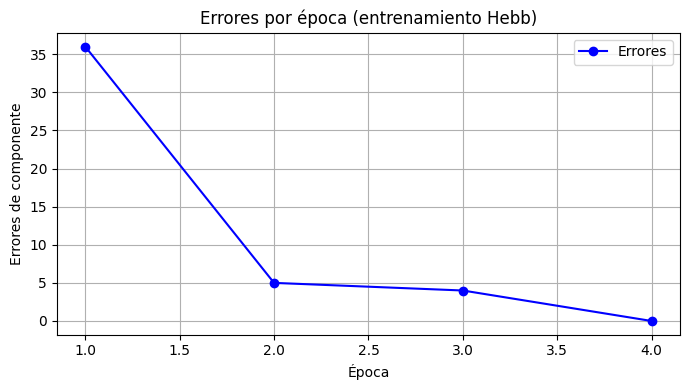

In [49]:
import matplotlib.pyplot as plt

# Gráfica de errores por época
plt.figure(figsize=(7,4))
plt.plot(hist_hebb["epoch"], hist_hebb["errors"], marker='o', color='blue', label="Errores")
plt.xlabel("Época")
plt.ylabel("Errores de componente")
plt.title("Errores por época (entrenamiento Hebb)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("figures/hebb_epochs.png", dpi=500)
plt.show()


#### 4.4 Entrenamientos con distintas tasas de aprendizaje

In [28]:
# ===== Experimentos con distintas tasas de aprendizaje =====
# 1) Hebb con distintos alphas
for a in [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0]:
    print("\n>>> alpha =", a)
    W_h, H_h = train_hebb_supervised(X_train, Y_train, alpha=a, shuffle=False, verbose=True)


>>> alpha = 0.0001
Epoch 001 | errores comp.:  35 | ||W||=  0.0074
Epoch 002 | errores comp.:   5 | ||W||=  0.0080
Epoch 003 | errores comp.:   4 | ||W||=  0.0085
Epoch 004 | errores comp.:   0 | ||W||=  0.0085

Convergencia: sin errores de componente en la época 4.

>>> alpha = 0.001
Epoch 001 | errores comp.:  34 | ||W||=  0.0727
Epoch 002 | errores comp.:   7 | ||W||=  0.0815
Epoch 003 | errores comp.:   4 | ||W||=  0.0864
Epoch 004 | errores comp.:   0 | ||W||=  0.0864

Convergencia: sin errores de componente en la época 4.

>>> alpha = 0.01
Epoch 001 | errores comp.:  34 | ||W||=  0.7310
Epoch 002 | errores comp.:   9 | ||W||=  0.8438
Epoch 003 | errores comp.:   4 | ||W||=  0.8917
Epoch 004 | errores comp.:   0 | ||W||=  0.8917

Convergencia: sin errores de componente en la época 4.

>>> alpha = 0.05
Epoch 001 | errores comp.:  36 | ||W||=  3.7895
Epoch 002 | errores comp.:   5 | ||W||=  4.0743
Epoch 003 | errores comp.:   4 | ||W||=  4.3220
Epoch 004 | errores comp.:   0 | ||W|

#### 4.5. Tabla del Experimento (Hebb + Escalón): Con al menos 5 valores de tasa de aprendizaje

Entrenamos la red **64→7** con regla de **Hebb supervisada** y función **escalón bipolar** para 5 valores distintos de la tasa de aprendizaje $\alpha$. Para cada $\alpha$, registramos:

- **Épocas requeridas** hasta convergencia (o tope de épocas).
- **Número de caracteres reconocidos** en **TEST**.
- **Porcentaje** de reconocimiento en **TEST**.
- **Lista de caracteres no reconocidos** en **TEST**.

**Lista de alphas ($\alpha$)** = [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0]

> **Supuestos de etiquetado en TEST:** si `TEST.dat` contiene las 7 letras en el orden \([A,B,C,D,E,J,K]\) **repetidas** el mismo número de veces, asignamos etiquetas repitiendo esa secuencia.


In [29]:
# =========================================================
# CONFIG: alphas, épocas, y utilidades para evaluación
# (Reutiliza X_train, Y_train y funciones definidas antes, incluyendo Hebb)
# =========================================================

import numpy as np
from pathlib import Path

# --------- Experimento sobre al menos 5 tasas de aprendizaje ----------
alphas = [1e-4, 1e-3, 1e-2, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 0.7, 1.0, 2.0]
max_epochs = 200  # tope razonable

results = []  # para guardar filas de la tabla

# ¿Cuántas repeticiones por clase hay en TEST?
from collections import Counter, defaultdict
counts_per_class_test = Counter(labels_test)  # p.ej., {'A':3, 'B':3, ...}

for alpha in alphas:
    # Entrenar Hebb con esta alpha
    W_hebb, hist = train_hebb_supervised(
        X=X_train,
        D=Y_train,
        alpha=alpha,
        max_epochs=max_epochs,
        shuffle=False,
        seed=123,
        verbose=False  # silenciamos para tabla limpia
    )
    # Épocas usadas (si convergió antes, hist tiene menos)
    epochs_used = len(hist["epoch"])

    # Evaluación en TEST
    Y_pred_test = step_bipolar(X_test @ W_hebb)          # (N_test, 7)
    match_vec   = np.all(Y_pred_test == Y_test, axis=1)  # True si vector completo coincide
    # Conteo de aciertos
    correct     = int(np.sum(match_vec))
    percent     = 100.0 * correct / X_test.shape[0]

    # Lista de caracteres no reconocidos (según su etiqueta)
    not_recognized = [lbl for lbl, ok in zip(labels_test, match_vec) if not ok]
    seen_index = defaultdict(int)  # cuántas veces hemos visto cada letra al iterar TEST
    pretty_fails = []
    for lbl_true, ok in zip(labels_test, match_vec):
        seen_index[lbl_true] += 1  # aumenta siempre, falle o acierte
        if not ok:
            reps = counts_per_class_test[lbl_true]
            if reps > 1:
                pretty_fails.append(f"{lbl_true}{seen_index[lbl_true]}")
            else:
                pretty_fails.append(lbl_true)

    results.append({
        "alpha": alpha,
        "epochs": epochs_used,
        "recognized": correct,
        "percent": percent,
        "not_recognized": not_recognized,
        "pretty_fails": pretty_fails
    })

# --------- Mostrar tabla de resultados ----------
print("Tabla de resultados (Hebb + Escalón)")
print("alpha\t\tepochs\trecognized\tpercent\t\tno_recognized\t\tno_recognized (con indices)")
for r in results:
    alpha = r["alpha"]
    epochs = r["epochs"]
    rec = r["recognized"]
    pct = r["percent"]
    miss = ",".join(r["not_recognized"]) if r["not_recognized"] else "-"
    missy = ",".join(r["pretty_fails"]) if r["pretty_fails"] else "-"
    print(f"{alpha:>0.4f}\t\t{epochs:>6d}\t{rec:>10d}\t{pct:>7.2f}%\t{miss}\t\t{missy}")


Tabla de resultados (Hebb + Escalón)
alpha		epochs	recognized	percent		no_recognized		no_recognized (con indices)
0.0001		     4	        16	  76.19%	C,A,B,A,D		C1,A2,B2,A3,D3
0.0010		     4	        16	  76.19%	C,A,B,A,D		C1,A2,B2,A3,D3
0.0100		     4	        14	  66.67%	A,C,A,B,K,A,D		A1,C1,A2,B2,K2,A3,D3
0.0500		     4	        17	  80.95%	C,A,B,A		C1,A2,B2,A3
0.0600		     4	        16	  76.19%	C,A,B,J,A		C1,A2,B2,J2,A3
0.0700		     4	        16	  76.19%	C,A,B,A,D		C1,A2,B2,A3,D3
0.0800		     4	        14	  66.67%	A,C,A,B,K,A,D		A1,C1,A2,B2,K2,A3,D3
0.0900		     4	        17	  80.95%	C,A,B,A		C1,A2,B2,A3
0.1000		     4	        17	  80.95%	C,A,B,A		C1,A2,B2,A3
0.5000		     4	        17	  80.95%	A,B,A,D		A2,B2,A3,D3
0.7000		     4	        16	  76.19%	A,B,K,A,D		A2,B2,K2,A3,D3
1.0000		     4	        17	  80.95%	A,B,A,D		A2,B2,A3,D3
2.0000		     4	        17	  80.95%	A,B,A,D		A2,B2,A3,D3


### 5. Entrenamiento con **Regla Delta** + **tanh** (salidas continuas, evaluación bipolar)

Trabajamos con una red **64→7** (63 píxeles + bias → 7 letras) y pesos en una matriz $ \mathbf{W}\in\mathbb{R}^{64\times 7} $.  
El **bias** ya está incluido como última característica (valor $+1$).

**Propagación (salida $j$)**  
$$
\mathrm{Net}_j=\sum_{i=1}^{64} w_{ij}\,x_i, 
\qquad
y_j=f(\mathrm{Net}_j), 
\qquad
f(\mathrm{Net}_j) = \dfrac{1 - e^{-2\mathrm{Net}_j}}{1 + e^{-2\mathrm{Net}_j}}
$$

**Error (vectorial) y gradiente local**  
$$
e=d-y, 
\qquad
g=f'(a)=1-y^2.
$$

**Regla Delta (actualización por patrón)**  
$$
\Delta w_{ij} = \alpha \, x_i \,(d_j - y_j)(1-y_j^2),
\qquad
w_{ij}(t+1) = w_{ij}(t) + \Delta w_{ij}.
$$

**Pérdida por época (LMSE)**  
$$
\mathrm{LMSE}=\frac{1}{N}\sum_{n=1}^{N}\frac{1}{2}\,(\mathbf{d}_n-\mathbf{y}_n)^2.
$$

**Criterio de paro**: parar si $ \mathrm{LMSE}\le \varepsilon $ o al alcanzar el máximo de épocas.  
Para evaluar reconocimiento, binarizamos la salida continua con umbral 0:  
$\hat{y}_j=\mathrm{sign}(y_j)\in\{-1,+1\}$ y comparamos con $\mathbf{d}$.


#### 5.1 Empezamos con definir la función de entrenamiento pues la vamos a llamar al menos 5 veces con distintas tasas de aprendizaje.

In [51]:
import numpy as np

# =========================================================
# Delta + tanh para red 64 -> 7
# Usa X_train, Y_train, X_test, Y_test ya cargados
# =========================================================

# función tanh estandar
def tanh_std(a: np.ndarray) -> np.ndarray:
    return np.tanh(a)

# función tanh según la definición de la práctica
def tanh_from_class(a):
    return (1 - np.exp(-2*a)) / (1 + np.exp(-2*a))

# Derivada de tanh en función de la salida y = tanh(a)
def dtanh_from_y_std(y: np.ndarray) -> np.ndarray:
    # f'(a) = 1 - tanh(a)^2  = 1 - y^2 (si y = tanh(a))
    return 1.0 - y**2

# Convierte salidas continuas a {-1,+1}
def bipolarize(Y_cont: np.ndarray) -> np.ndarray:
    # convierte salidas continuas a {-1,+1}
    return np.where(Y_cont >= 0.0, 1.0, -1.0)

# Función de entrenamiento Delta supervisado
def train_delta_supervised(
    X: np.ndarray,         # (N, 64)
    D: np.ndarray,         # (N, 7) bipolares
    alpha: float = 0.1,
    eps: float = 5e-2,     # umbral LMSE (ajústalo si deseas)
    max_epochs: int = 500,
    shuffle: bool = False,
    seed: int | None = None,
    verbose: bool = True
):
    """
    Regla Delta (tanh) con actualización on-line por patrón:
        ΔW = α * x * ( (d - y) ⊙ (1 - y^2) )^T
    Métricas por época: LMSE, errores de componente y exactitud simbólica (bipolarizada).
    """
    N, d_in = X.shape
    _, d_out = D.shape
    rng = np.random.default_rng(seed)

    # pesos en cero (como en la práctica)
    W = np.zeros((d_in, d_out), dtype=float)

    history = {"epoch": [], "lmse": [], "comp_errors": [], "acc_symbol": []}

    for epoch in range(1, max_epochs + 1):
        if shuffle:
            idx = rng.permutation(N)
            X_epoch, D_epoch = X[idx], D[idx]
        else:
            X_epoch, D_epoch = X, D

        sq_errs = []
        comp_errs = 0

        for x, d in zip(X_epoch, D_epoch):
            a = x @ W              # (7,)
            y = tanh_std(a)        # (7,)
            e = d - y              # (7,)
            g = dtanh_from_y_std(y)# (7,)

            # errores de componente (para logging)
            comp_errs += np.count_nonzero(np.sign(y) != d)

            # ΔW = α * x * ((e ⊙ g))^T
            W += alpha * np.outer(x, e * g)

            sq_errs.append(0.5 * np.sum(e**2))

        # métricas por época
        lmse = float(np.mean(sq_errs))
        Y_train_cont = tanh_std(X @ W)
        Y_train_bip  = bipolarize(Y_train_cont)
        acc_symbol = float(np.mean(np.all(Y_train_bip == D, axis=1)))

        history["epoch"].append(epoch)
        history["lmse"].append(lmse)
        history["comp_errors"].append(int(comp_errs))
        history["acc_symbol"].append(acc_symbol)

        if verbose:
            print(f"Epoch {epoch:03d} | LMSE={lmse:.6f} | errComp={comp_errs:3d}")

        if lmse <= eps:
            if verbose:
                print(f"\nConvergencia por LMSE ≤ {eps} en la época {epoch}.")
            break

    return W, history

#### 5.2 Prueba con solo un alpha clásico de 0.1

In [52]:
# ==========================
# 1) Prueba con alpha = 0.1 (detalle de épocas)
# ==========================
alpha = 0.1
eps = 5e-2     # Probamos con un valor típico de tolerancia de error epsilon
max_epochs = 500

W_delta, hist_delta = train_delta_supervised(
    X=X_train,
    D=Y_train,
    alpha=alpha,
    eps=eps,
    max_epochs=max_epochs,
    shuffle=False,
    seed=123,
    verbose=True
)

# ==========================
# Evaluación rápida en TEST (bipolarizada)
# ==========================
Y_test_cont = np.tanh(X_test @ W_delta)
Y_test_bip  = bipolarize(Y_test_cont)
correct_mask = np.all(Y_test_bip == Y_test, axis=1)
recognized   = int(correct_mask.sum())
percent      = 100.0 * recognized / len(Y_test)

print("\n--- Resumen TEST.dat (Delta + tanh) ---")
print(f"Caracteres reconocidos: {recognized}/{len(Y_test)}  ({percent:.2f}%)")

print("Primeras 5 predicciones (bipolarizadas) vs objetivos:")
for i in range(min(5, len(Y_test))):
    print(f"Patrón {i+1:02d} | y = {Y_test_bip[i]} | d = {Y_test[i]}")

Epoch 001 | LMSE=2.524100 | errComp= 36
Epoch 002 | LMSE=1.003961 | errComp= 13
Epoch 003 | LMSE=0.618264 | errComp=  7
Epoch 004 | LMSE=0.371453 | errComp=  4
Epoch 005 | LMSE=0.285394 | errComp=  3
Epoch 006 | LMSE=0.284309 | errComp=  3
Epoch 007 | LMSE=0.290407 | errComp=  3
Epoch 008 | LMSE=0.283876 | errComp=  3
Epoch 009 | LMSE=0.280112 | errComp=  3
Epoch 010 | LMSE=0.339164 | errComp=  4
Epoch 011 | LMSE=0.282695 | errComp=  3
Epoch 012 | LMSE=0.324256 | errComp=  4
Epoch 013 | LMSE=0.197722 | errComp=  2
Epoch 014 | LMSE=0.144815 | errComp=  2
Epoch 015 | LMSE=0.015150 | errComp=  0

Convergencia por LMSE ≤ 0.05 en la época 15.

--- Resumen TEST.dat (Delta + tanh) ---
Caracteres reconocidos: 20/21  (95.24%)
Primeras 5 predicciones (bipolarizadas) vs objetivos:
Patrón 01 | y = [ 1. -1. -1. -1. -1. -1. -1.] | d = [ 1. -1. -1. -1. -1. -1. -1.]
Patrón 02 | y = [-1.  1. -1. -1. -1. -1. -1.] | d = [-1.  1. -1. -1. -1. -1. -1.]
Patrón 03 | y = [-1. -1.  1. -1. -1. -1. -1.] | d = [-1

#### 5.3 Gráfica de convergencia del aprendizaje (Regla Delta)

La siguiente figura muestra la evolución del **Error Cuadrático Medio** (LMSE) por época durante el entrenamiento con la regla Delta y función de activación tangente hiperbólica.  
El error se calcula como:

$$
E = \frac{1}{2}(d_i - y_i)^2
$$

y el **promedio del error por época** como:

$$
\mathrm{LMSE} = \frac{1}{N}\sum_{i=1}^{N} E_i
$$

El valor de $\alpha = 0.05$ presentó la mejor convergencia, alcanzando $\mathrm{LMSE} \le 0.05$ en la época 6.


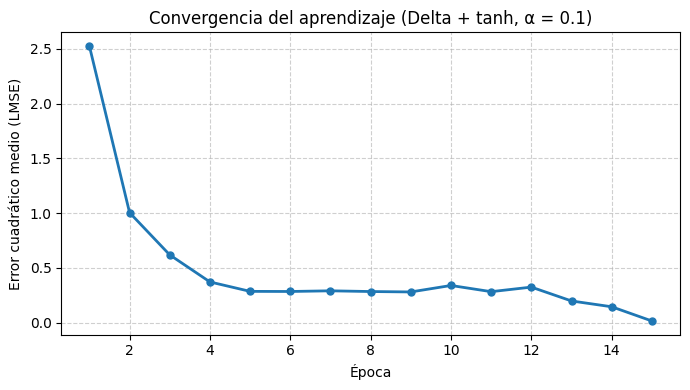

In [53]:
import matplotlib.pyplot as plt

# =============================================
# Gráfica de convergencia (LMSE vs época)
# Usando la misma alpha que Hebb (alpha = 0.1)
# =============================================

epochs = hist_delta["epoch"]
lmse = hist_delta["lmse"]

plt.figure(figsize=(7,4))
plt.plot(epochs, lmse, marker='o', linewidth=2, markersize=5)
plt.title("Convergencia del aprendizaje (Delta + tanh, α = 0.1)")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio (LMSE)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("figures/delta_epochs.png", dpi=500)
plt.show()


#### 5.4 Entrenamientos con distintas tasas de aprendizaje

In [54]:
# ==========================
# 2) Tabla con múltiples tasas de aprendizaje (Delta + tanh)
# ==========================

# --------- Experimento sobre al menos 5 tasas de aprendizaje ----------
alphas = [1e-4, 1e-3, 1e-2, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 0.7, 1.0, 2.0]
eps = 5e-2     # Probamos con un valor típico de tolerancia de error epsilon
max_epochs = 500
rows = []

for a in alphas:
    # Entrenamiento con esta tasa de aprendizaje
    W_tmp, h = train_delta_supervised(
        X=X_train, D=Y_train,
        alpha=a, eps=eps, max_epochs=max_epochs,
        shuffle=False, seed=123, verbose=False
    )

    epochs_used = len(h["epoch"])

    # Evaluación en TEST
    Yt_cont = np.tanh(X_test @ W_tmp)
    Yt = bipolarize(Yt_cont)
    match_vec = np.all(Yt == Y_test, axis=1)
    correct = int(match_vec.sum())
    percent = 100.0 * correct / len(Y_test)

    # Lista de caracteres no reconocidos
    if 'labels_test' in globals():
        not_recognized = [lbl for lbl, ok in zip(labels_test, match_vec) if not ok]
        not_recognized_idx = [f"{lbl}{i+1}" for i, (lbl, ok) in enumerate(zip(labels_test, match_vec)) if not ok]
    else:
        not_recognized = [f"idx{idx}" for idx, ok in enumerate(match_vec) if not ok]
        not_recognized_idx = not_recognized

    rows.append({
        "alpha": a,
        "epochs": epochs_used,
        "recognized": correct,
        "percent": percent,
        "not_recognized": not_recognized,
        "not_recognized_idx": not_recognized_idx
    })

# ----------------------------
# Imprimir tabla en formato similar a Hebb
# ----------------------------
print("\nTabla de resultados (Delta + tanh)")
print("alpha\t\tepochs\trecognized\tpercent\t\tno_recognized\t\tno_recognized (indices)")
for r in rows:
    a = r["alpha"]
    ep = r["epochs"]
    rec = r["recognized"]
    pct = r["percent"]
    miss = ",".join(r["not_recognized"]) if r["not_recognized"] else "-"
    miss_idx = ",".join(r["not_recognized_idx"]) if r["not_recognized_idx"] else "-"
    print(f"{a:>0.4f}\t\t{ep:>6d}\t{rec:>10d}\t{pct:>7.2f}%\t{miss:15s}\t{miss_idx}")



Tabla de resultados (Delta + tanh)
alpha		epochs	recognized	percent		no_recognized		no_recognized (indices)
0.0001		   500	        21	 100.00%	-              	-
0.0010		   134	        21	 100.00%	-              	-
0.0100		    13	        21	 100.00%	-              	-
0.0500		     6	        21	 100.00%	-              	-
0.0600		     6	        21	 100.00%	-              	-
0.0700		     6	        19	  90.48%	C,A            	C3,A15
0.0800		     7	        20	  95.24%	A              	A15
0.0900		    12	        20	  95.24%	A              	A15
0.1000		    15	        20	  95.24%	A              	A15
0.5000		   500	         4	  19.05%	B,C,E,J,K,A,B,C,E,J,K,A,B,C,E,J,K	B2,C3,E5,J6,K7,A8,B9,C10,E12,J13,K14,A15,B16,C17,E19,J20,K21
0.7000		   500	         5	  23.81%	B,C,D,E,J,K,B,C,E,J,B,C,D,E,J,K	B2,C3,D4,E5,J6,K7,B9,C10,E12,J13,B16,C17,D18,E19,J20,K21
1.0000		   500	         7	  33.33%	C,D,E,J,K,C,E,J,K,C,D,E,J,K	C3,D4,E5,J6,K7,C10,E12,J13,K14,C17,D18,E19,J20,K21
2.0000		   500	         4	  19.05%	